# Baby Names Analysis

The goal of this project is to analyze the popularity of baby names in the US based on Social Security card applications. The name counts are grouped by year from 1910 to 2018. All 50 states plus the District of Colombia are represented with their own text file of data. There are 5 features in this data set: *state*, *sex*, *year*, *name*, *count*. In total, there are 6,028,151 records.

There are 5 parts to this analysis: 
1. Top 10 Names
1. Most Consistently Used Names
1. Gender Differences in Naming
1. Name Choice Forecasting
1. State-specific Name Popularity

This analysis will use the *pandas* library to put the data into a convenient format that will aid in the analyses performed. In addition, a number of utility functions provided by DataCamp's *dc_stat_think* library will be used which are useful for performing experiments using data. The imports for each are included below.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import dc_stat_think as dcst
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import random
import warnings
from scipy.stats import chisquare
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
# seed random number generator to ensure consistent results
random.seed( 20 )

In [4]:
# using Seaborn styling for visualizations
sns.set(style="ticks")
sns.set(font_scale = 2)
sns.set_style("darkgrid")

In [5]:
# suppress warnings
warnings.simplefilter('ignore')

Because the data is grouped into CSV files by state, pandas dataframes are created for each state and concatenated together to form one large dataframe for the analyses that follow.

In [6]:
# read in all state data
df = pd.concat(
                (
                    pd.read_csv(
                            filename, 
                            header=None,
                            names = [
                                "state",
                                "sex",
                                "year",
                                "name",
                                "count"
                            ]
                    ) for filename in glob.glob("namesbystate/*.TXT")
                )
)  

In [7]:
df.shape

(6028151, 5)

In [8]:
df.head()

,state,sex,year,name,count
0,IN,F,1910,Mary,619
1,IN,F,1910,Helen,324
2,IN,F,1910,Ruth,238
3,IN,F,1910,Dorothy,215
4,IN,F,1910,Mildred,200


### 1. Top-10 Most Popular Names

As a warm-up exercise, it would be interesting to know which are the top 10 male and top 10 female baby names. The approach for generating these results involves:

1. filter by gender ("M" or "F")
1. select the *name* and *count* columns of the resulting dataframe
1. group the results by name and sum the counts for each name
1. sort the results by count in descending order
1. display the first 10 results from the dataframe

Because the dataframe manipulations for males and females only differs based on the filter performed on the sex column, a function for generating the top *n* names reduces code duplication and is implemented below:

In [9]:
def top_names(gender, n=10):
    '''
    Get the top n names based on gender
    
    gender - string representing gender ('M' or 'F')
    n - the number of names to return
    '''
    
    gender_df = df[df.sex==gender][["name", "count"]] 
    agg_names = gender_df.groupby(["name"]).sum()
    sorted_names = agg_names.sort_values("count", ascending=False)
    return sorted_names.head(n)

In [10]:
# top 10 male names
top_names('M')

,count
name,
James,4997327
John,4869607
Robert,4734038
Michael,4349307
William,3890923
David,3597725
Richard,2539873
Joseph,2522812
Charles,2273068


In [11]:
# top 10 female names
top_names('F')

,count
name,
Mary,3741196
Patricia,1569022
Elizabeth,1537684
Jennifer,1466161
Linda,1447943
Barbara,1424221
Margaret,1130920
Susan,1109309
Dorothy,1053390


According to Social Security application data, James is the most popular male name and Mary (by a large margin) is the most popular female name.

### 2. Most Consistently Used Names

Names may rise and fall in popularity for reasons that are difficult to understand based on the data available from Social Security applications. What can be understood, however, is how consistently names have been given historically. This analysis is only using names used on female applications. Naming consistency will be investigated by calculating the variance of the name proportions over a 50 year period between 1950 and 2000. Only names with a minimum count of 100 applications in each year in the 50 year period will be included in the analysis.

In [12]:
# get all female names in date range between 1950-2000
female_1950_2000 = df[(df.sex=="F") & (df.year.isin(range(1950,2000)))][["year","name", "count"]]

In [13]:
# sum counts by name and year
name_year = female_1950_2000.groupby(["name", "year"]).sum()
name_year.head()

count
name    year       
Aaleyah 1997      5
Aaliya  1997     10
Aaliyah 1977     26
        1978     26
        1979     22

In [14]:
# determine how many female baby names had at least 100 applications in every year under consideration 
names_min100 = name_year[name_year["count"] >= 100].groupby(["name"]).count()
names_min100.head()

,count
name,
Aaliyah,6
Aaron,3
Abagail,4
Abbey,22
Abbie,22


In [15]:
# filter out names that did not have 100 applications in every yearr
name_year = female_1950_2000[female_1950_2000.name.isin(names_min100.index.get_level_values('name'))]
name_year.set_index(["name", "year"], inplace=True)
name_year.head()

,,count
name,year,
Linda,1950,2262
Mary,1950,1517
Patricia,1950,1085
Deborah,1950,1084
Susan,1950,938


In [16]:
# compute total application counts by year
year_sums = pd.DataFrame(female_1950_2000.groupby(["year"])["count"].sum())
year_sums.head()

,count
year,
1950,1610039
1951,1695480
1952,1745385
1953,1770245
1954,1827959


In [17]:
# calculate the percentage of total names for each name per year
name_percentages = name_year.apply(lambda row: row["count"]/year_sums.loc[row.name[1]]*100, axis=1)
name_percentages.rename(columns={"count": "perc"}, inplace=True)
name_percentages.head()

,,perc
name,year,
Linda,1950,0.140493
Mary,1950,0.094221
Patricia,1950,0.067390
Deborah,1950,0.067328
Susan,1950,0.058259


In [18]:
# calculate the variances for each name during the time period
variances = {}
for name in set(name_year.index.get_level_values(0)):
    values = name_percentages.xs(key=name, level="name").perc
    variances[name] = values.var()

In [19]:
# convert variances dictionary into pandas data frame
results = pd.DataFrame(variances.items(), columns=["name", "vars"])
results.set_index("name", inplace=True)

In [20]:
# order variances in ascending order
results.reindex(results.sort_values(by='vars').index).head()

,vars
name,
Louella,1.178639e-08
Sheilah,1.241235e-08
Leisha,1.349056e-08
Sherree,1.391618e-08
Cleo,1.427606e-08


The 5 names that changed the least in relative popularity from 1950-2000 were (in order of consistency) Louella, Sheilah, Leisha, Sherree, and Cleo.

### 3. Gender Differences in Naming

The data being explored in this notebook is not very complex. There are only 5 features. However, one of the most interesting categories present in the data is gender. This section of the analysis will focus on gender differences in naminig.

#### Question: Is there a difference between male and female applications across years based on the data?

In [21]:
# generate the total number of male and female baby names per year
counts_by_year_sex = df[["year", "sex", "count"]].groupby(["year", "sex"]).sum().reset_index()
counts_by_year_sex.head(10)

,year,sex,count
0,1910,F,352089
1,1910,M,164226
2,1911,F,372381
3,1911,M,193441
4,1912,F,504298
5,1912,M,383703
6,1913,F,566973
7,1913,M,461607
8,1914,F,696906
9,1914,M,596440


In [22]:
# pivot dataframe to display counts with year in rows and sex in columns
count_by_sex_df = counts_by_year_sex.pivot(index='year', columns='sex', values='count')
count_by_sex_df[['F', 'M']].head()

sex,F,M
year,,
1910,352089,164226
1911,372381,193441
1912,504298,383703
1913,566973,461607
1914,696906,596440


In [23]:
count_by_sex_df['portion_female'] = count_by_sex_df['F'] / (count_by_sex_df['F'] + count_by_sex_df['M'])

The dataframe above now contains a column that represents the portion of female applications per year. 

In [24]:
count_by_sex_df.head()

sex,F,M,portion_female
year,,,
1910,352089,164226,0.681927
1911,372381,193441,0.658124
1912,504298,383703,0.567903
1913,566973,461607,0.551219
1914,696906,596440,0.538840


With the data in a convenient format for analysis, some exploratory data analysis can now be performed.

In [25]:
# Empirical Cumulative Distribution Function
x_cdf, y_cdf = dcst.ecdf(count_by_sex_df['portion_female'])
x = [count_by_sex_df['portion_female'].min(), count_by_sex_df['portion_female'].max()]
y = [0.5, 0.5]

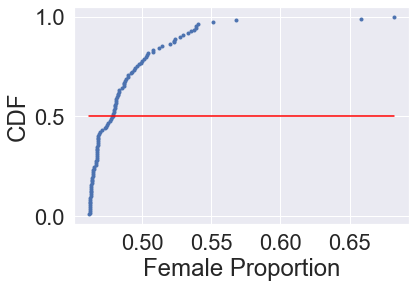

In [26]:
_ = plt.plot(x_cdf, y_cdf, marker='.', linestyle='none')
y = [0.5, 0.5]
_ = plt.plot(x, y, color='red')
_ = plt.xlabel('Female Proportion')
_ = plt.ylabel('CDF')

The median proportion of female births appears to be less than 0.5 according to the plot of the cumulative distrubition function. While this provides some evidence that there have been fewer female births historically than male births, we need additional evidence to have confidence in this observation. 

In [27]:
# calculate the average portion of females born per year
mean_prop = count_by_sex_df['portion_female'].mean()

# create 10000 bootstrap replicates of the portion of female births
bs_replicates = dcst.draw_bs_reps(count_by_sex_df['portion_female'].to_numpy(), np.mean, 10000 )

# create a 95% confidence interval using the bootstrap replicates
conf_interval = np.percentile(bs_replicates, [2.5, 97.5])

print("Mean proportion of female births : %f" % mean_prop)
print("95% CI for mean proportion of female births: ", conf_interval)

Mean proportion of female births : 0.487711
95% CI for mean proportion of female births:  [0.48172149 0.49464529]


We see that the average value for the proportion of females births indicates that the number of male births is on average higher than female births. In addition, the 95% confidence interval does not include 0.5 (a 50/50 gender split). This provides some evidence that there actually is a larger proportion of male births than female births. Let's go further and perform a hypothesis test regarding differences in birth by gender.

*Hypothesis*: The proportion of female and male annual birth counts in the U.S. based on social security applications is equal.

*Test Statistic*: Average proportion of births that are labeled as female.

From here, we calculate the p-value for our test statistic to infer how extreme this value is based on our boostrap replicates. 

In [28]:
p_val = np.sum(bs_replicates <= mean_prop) / len(bs_replicates)

print("p-value: %f" % p_val)

p-value: 0.508600


This p-value indicates that about 52% of the test statistics from the bootstrap replicates are at least as small as the one observed in this data set. This indicates that there is a relatively high probability that a proportion less than half would be observed simply by chance. Therefore, there is insufficient evidence to reject the hypothesis that the proportion of female and male annual birth counts in the U.S. based on Social Security applications is equal. While the evidence in the data from Social Security applications is not strong enough to reject the hypothesis that more males than females are born in the United States, it turns out that there is evidence that such a difference does exist [based on the country in which the birth occurs](https://www.pewresearch.org/fact-tank/2013/09/24/the-odds-that-you-will-give-birth-to-a-boy-or-girl-depend-on-where-in-the-world-you-live/).

Another interesting question to investigate is also a gendered one: 

#### Question: Are male and female name lengths equally distributed?

To explore this question, we first need to massage our data into a form that will help to understand name lengths by gender. The series below includes two columns: *name* and *gender*. This is a listing of all unique baby name/gender combinations summed over states and birth years. 

In [29]:
name_and_gender = df.groupby(['name', 'sex']).size()

In [30]:
name_and_gender.head()

name     sex
Aaban    M        2
Aadan    M        4
Aadarsh  M        1
Aaden    M      256
Aadhav   M        6
dtype: int64

The (name, sex)-index for this series has most of the information that we want. Therefore, a dataframe with just these values would be useful.

In [31]:
# convert series into a DataFrame
name_gender_df = name_and_gender.reset_index()

In [32]:
# remove the counts of each name/gender combination
del name_gender_df[0]

In [33]:
len(name_gender_df)

34637

As evaluation of the expression above indicates, there are close to 35k names in this dataset. This isn't a large dataset. However, for the purposes of this analysis, the dataset can be reduced. There are names in this list which appear twice. These are unisex names that have been assigned to both male and female births. The length of these names will be represented in the distributions of name lengths for both genders and, essentially, cancel each other out. Therfore, we can discard these names from the dataset because this analysis will be focused on the comparison of name lengths by gender. How many names fall into this category?

In [34]:
# group by names and calculate number of times the name appears in the list
name_counts = name_gender_df.groupby(['name']).size()

In [35]:
name_counts[name_counts > 1]

name
Aaliyah    2
Aaren      2
Aarin      2
Aaron      2
Aarya      2
          ..
Zuri       2
Zuriel     2
Zyaire     2
Zyan       2
Zyon       2
Length: 3042, dtype: int64

The number of unisex names is a bit over 3k. We can reduce our dataset by twice this amount! So, let's do that.

In [36]:
name_gender_df = name_gender_df[~name_gender_df['name'].isin(name_counts[name_counts > 1].index)]

In [37]:
len(name_gender_df)

28553

An interesting question that can be explored in this data is if there is more diversity in baby names between genders in the U.S. This can be computed with a simple groupby.

In [38]:
name_gender_df.groupby(['sex']).size()

sex
F    17810
M    10743
dtype: int64

There are almost twice as many female names as male names. But is there really a difference? Let's run a quick chi-square test on these counts to determine if a statistical difference exists between these counts. To make this question more precise:

*Hypothesis*: There is no difference in the number of unique female names compared to the number of unique male names based on social security applications in the U.S.

Test statistic: Chi-square statistic

The computed p-value is interpreted as the percentage of chi-square statistics we would expect to be as small or smaller than the one computed for the observed counts simply by chance.

In [39]:
chisq_stat, p = chisquare(name_gender_df.groupby(['sex']).size().to_numpy())

In [40]:
p

0.0

Therefore, we have pretty strong evidence that there actually is a difference in the number of unique female names compared to the number of unique male names based on U.S. social security applications. Recall, the 3k+ names that were tossed earlier in this analysis. These names would have contributed equally to both counts of unique names and, therefore, the removal of those names does not change the result that was discovered in the Chi-Square test.

That was an interesting aside but let's now return the question that motivated extracting the unique names: differences in name length by gender. The first thing to do is append the length of each name to the dataset.

In [41]:
name_gender_df['name_length'] = name_gender_df['name'].str.len()

In [42]:
name_gender_df.head()

,name,sex,name_length
0,Aaban,M,5
1,Aadan,M,5
2,Aadarsh,M,7
3,Aaden,M,5
4,Aadhav,M,6


As usual, let's perform some exploratory visual analysis of the data. We can visually compare the distribution of name lengths between males and females using overlapping histograms.

In [43]:
male_name_lengths = name_gender_df[name_gender_df.sex=='M'].name_length
female_name_lengths = name_gender_df[name_gender_df.sex=='F'].name_length

min_length = min([min(male_name_lengths), min(female_name_lengths)])
max_length = max([max(male_name_lengths), max(female_name_lengths)])

bins = np.arange(min_length, max_length) - 0.5 # center bins on length markers

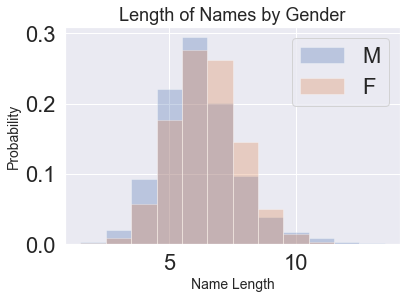

In [44]:
_ = plt.hist(male_name_lengths, alpha = 0.3, density=True, bins=bins)
_ = plt.hist(female_name_lengths, alpha = 0.3, density=True, bins=bins)
_ = plt.xlabel('Name Length', fontsize=14)
_ = plt.ylabel('Probability', fontsize=14)
_ = plt.title('Length of Names by Gender', fontsize=18)
_ = plt.legend(('M', 'F'), loc='upper right')
plt.show()

These histograms provide visual evidence that longer names appear to make up a larger proportion of the distribution of female name lengths compared to male name lengths. Stated more simply, we have reason to be believe that female names are longer than male names based on the dataset being analyzed here. Let's now explore if the cumulative distribution functions for these datasets are provide further evidence for this belief.

In [45]:
# generate data from the ECDF
x_male, y_male = dcst.ecdf(male_name_lengths)
x_female, y_female = dcst.ecdf(female_name_lengths)

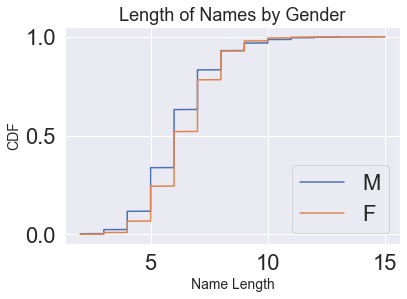

In [46]:
_ = plt.plot(x_male, y_male)
_ = plt.plot(x_female, y_female)
_ = plt.xlabel('Name Length', fontsize=14)
_ = plt.ylabel('CDF', fontsize=14)
_ = plt.title('Length of Names by Gender', fontsize=18)
_ = plt.legend(('M', 'F'), loc='lower right')
plt.show()

The ECDFs support what was observed in the histogram plots. A larger percentage of male names have shorter lengths compared to the percentage of female names. Now is a good time to formally state the hypothesis we would like to investigate.

Hypothesis: Female names are on average the same length as male names according to U.S. Social Security applications.
    
Test Statistic: Difference in mean name length between female and male applications
    
The test statistic will be compared to bootstrap replicates to compute the percentage of test statitistics that would be as extreme or more extreme than the value observed.

Now, let's construct confidence intervals to see if repeated experiments following the same distribution for name lengths supports what we are seeing. We are going to generate bootstrap replicates for both data sets to construct 95% confidence intervals for the mean length of names for each gender.

In [47]:
# setting number of replicates
NUM_REPS = 10000

# average female name length
f_name_length_avg = np.mean(female_name_lengths)

# average male name length
m_name_length_avg = np.mean(male_name_lengths)

# draw 10,000 bootstrap replicates from the female data and construct 95% CI
f_bs_reps = dcst.draw_bs_reps(female_name_lengths, np.mean, NUM_REPS)
f_conf_inter = np.percentile(f_bs_reps, [2.5, 97.5])

# draw 10,000 bootstrap replicates from the male data and construct 95% CI
m_bs_reps = dcst.draw_bs_reps(male_name_lengths, np.mean, NUM_REPS)
m_conf_inter = np.percentile(m_bs_reps, [2.5, 97.5])

print("Average female name length: %f" % f_name_length_avg)
print("95% Confidence Interval:", f_conf_inter)
print("Average male name length: %f" % m_name_length_avg)
print("95% Confidence Interval:", m_conf_inter)

Average female name length: 6.479281
95% Confidence Interval: [6.45839416 6.50078608]
Average male name length: 6.179652
95% Confidence Interval: [6.14995811 6.2088802 ]


Interesting...the average female and male name lengths don't appear to be as different as we might have expected. Let's also look at the 95% confidence interval of the difference in means and calculate a p-value for the observed data.

In [48]:
# difference of observed means
diff_means = f_name_length_avg - m_name_length_avg

# difference of means between replicates
diff_reps = f_bs_reps - m_bs_reps

# construct 95% CI
diff_conf_inter = np.percentile(diff_reps, [2.5, 97.5])

# compute p-value
p_val = np.sum(diff_reps >= diff_means) / NUM_REPS

print("Difference of means between female and male name lengths: %f" % diff_means)
print("95% Confidence Interval:", diff_conf_inter)
print("p = %f" % p_val)

Difference of means between female and male name lengths: 0.299629
95% Confidence Interval: [0.26289908 0.33613037]
p = 0.502400


This difference in means is not a very extreme value. The p-value indicates that through repeatedly running this experiment, about 50% of the time we would expect to observe a difference between average female and male name lengths as extreme if not more extreme than the difference observed from the social security application data. Therefore, we don't have sufficient evidence to reject the hypothesis that the difference in mean name length is different between male and females according to U.S. Social Security applications. To be clear, there is an obvious difference in the means based on the analysis above. However, this difference is too small to conclude that random chance is not responsible for the difference.

### 4. Name Choice Forecasting

Sarah is a very common name. I know and have met quite a few people with this name in my life. This analysis will focus on a specific subset of applicatiions for people named Sarah between the years 1988 to 2018 in the Pacific Coast states (California, Oregon, and Washington). The goal is to use the results of a timeseries analysis of the years under investigation to predict the number of applicatioins for Sarah in 2019.

In [49]:
# filter for Sarah applications, between from 1988 through 2018 in California, Oregon, and Washington
df[(df.name=="Sarah") & (df.year.isin(range(1988, 2019))) & (df.state.isin(["CA","OR","WA"]))].head()

,state,sex,year,name,count
26723,OR,F,1988,Sarah,374
27283,OR,F,1989,Sarah,354
27851,OR,F,1990,Sarah,296
28453,OR,F,1991,Sarah,305
29053,OR,F,1992,Sarah,283


In [50]:
# create a dataframe with just the summed (for the 3 states) data of interest
sub_df = df[
            (df.name=="Sarah") & 
            (df.year.isin(range(1988, 2019))) & 
            (df.state.isin(["CA","OR","WA"]))
        ][["year", "count"]].groupby(["year"]).sum()
sub_df.head()

,count
year,
1988,3969
1989,3972
1990,3707
1991,3604
1992,3531


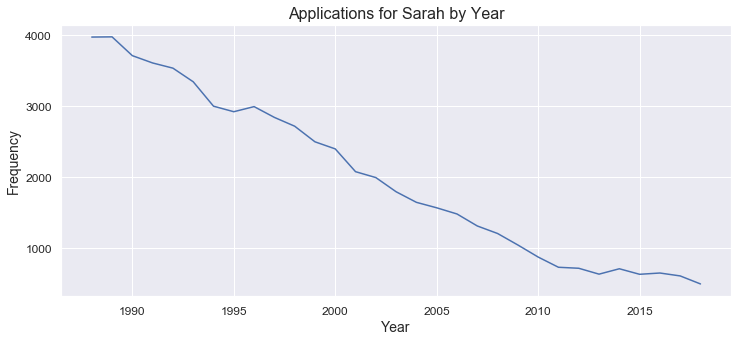

In [51]:
ax = sub_df.plot(legend=False, figsize=(12, 5))
plt.title("Applications for Sarah by Year", size=16)
plt.xlabel("Year", size = 14)
plt.ylabel("Frequency", size = 14)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

A plot of the number of people named "Sarah" that were born each year from 1988-2018 in the Pacific Coast states can be found in the figure above. The plot shows a decreasing number of peopled named "Sarah" throughout the 30 year period under investigation. 

In [52]:
# get the total number of applications in the 3 states over this time period
sub_tot_df = df[
            (df.year.isin(range(1988, 2019))) & 
            (df.state.isin(["CA","OR","WA"]))
        ][["year", "count"]].groupby(["year"]).sum()
sub_tot_df.head()

,count
year,
1988,575020
1989,611551
1990,656204
1991,652698
1992,643692


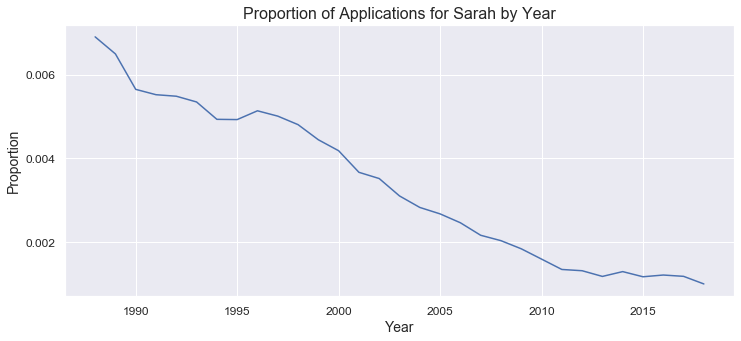

In [53]:
ax = (sub_df/sub_tot_df).plot(legend=False, figsize=(12, 5))
plt.title("Proportion of Applications for Sarah by Year", size=16)
plt.xlabel("Year", size = 14)
plt.ylabel("Proportion", size = 14)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()

However, to account for any differences that may be due to birth rates in each year, the plot above is the same data as a proportion of the total number of Social Security applications from these states each year. There seems to be a bit of a leveling off with regards to the frequency of the name Sarah in these states during the final years under analysis. It is very clear that the popularity of the name "Sarah" is declining within this time period.

In [54]:
sarah_df = sub_df/sub_tot_df
sarah_df.rename(columns={'count': 'prop'}, inplace=True)
sarah_df.head()

,prop
year,
1988,0.006902
1989,0.006495
1990,0.005649
1991,0.005522
1992,0.005486


To provide future predictions for the year 2019, we can use an Autoregressive Integrated Moving Average (ARIMA) Model and reduce over-fitting by using a walk-forward optimization approach for fitting the model. An ARIMA model has a few parameters which need to be provided. One required parameter is the number of periods of data that should be considered in making a prediction (a.k.a. the "lag"). It is useful to plot the autocorrelation in the data in order to determine this parameter.

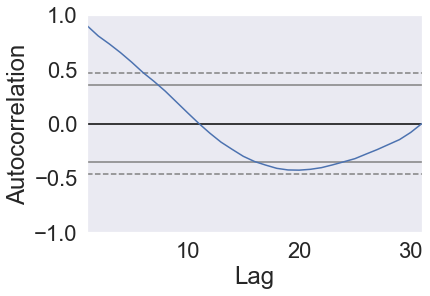

In [55]:
_ = autocorrelation_plot(sarah_df)
plt.show()

There is a positive correlation in this data within the first 10-12 lags. If we consider an autocorrelation at or above 0.5 to be signficant, the first 6 lags meet this threshold. Therefore, a lag order of 6 for this model seems reasonable (p=6).

Because we want the time series to be stationary (meaning that the the process which generates the time series is consistent over time), it is necessary to first see if the data is stationary. This can be done using the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity. The null hypothesis for this test is that the observed data is stationary.

In [56]:
# execute the KPSS test
kpss_stat, p_val, _, crit = kpss(sarah_df, nlags='legacy')

In [57]:
kpss_stat, p_val, crit

(0.43559244539655906,
 0.06181360112217283,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

We would expect to see a test statistic that is this large or greater a little over 6% of the time. The null hypothesis is that the observations are stationary. Therefore, we have some confidence that we can safely consider these observations to be stationary. While we can move forward with an ARIMA model without differencing, it is worthwhile to determine if we can have more confidence in the stationarity of the observations after applying differencing. The numpy *diff()* function performs differencing on the data.

In [58]:
kpss_stat, p_val, _, crit = kpss(np.diff(sarah_df['prop']))

In [59]:
kpss_stat, p_val, crit

(0.3335558039439202,
 0.1,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Based on the differenced observations, we would expect to see a test statistic that is this large or greater about 10% of the time. Again the null hypothesis is that the observations are stationary. After differencing, the observations can be more confidently assumed to be stationary. Therefore, we will be performing differencing in this model (d=1).

In the interest of simplicity, this model will not incorporate a moving average window (q=0).

Recall the autocorrelation plot generated previously. The lag number producing the highest correlation appears to be around 6 or 7 lag periods:

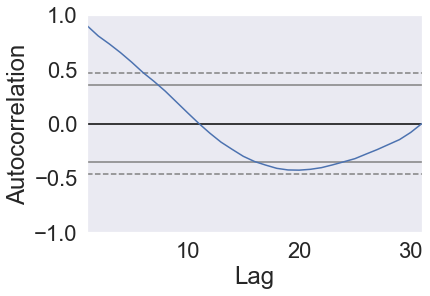

In [60]:
_ = autocorrelation_plot(sarah_df)
plt.show()

Perhaps, the right cut-off in lag periods is 8. It's not completely clear from the plot. Addressing the problem of which lag order produces the best model can be determined by using the data that is available for testing model performance for each of the 3 possible values for the lag order.

Specifically, the following procedure will be used to test the performance of models of different lag orders:  
1. Split the data into a training and testing set (70/30)
1. For each of the lag periods being tested,
    1. For each observation in the test set of observations
        1. Create model for window of time
        1. Fit the model
        1. Predict the proportion of applications using the name Sarah for the next year using the model
        1. Record the prediction
        1. Add the next observation from the observed data that is outside of the current sample to the training data
    1. Calculate the mean squared error between the predicted proportions and the observed proportions
1. Finally, choose lag order that generates the smallest mean squared error

By using this approach, we can optimize the parameters (specifically, lag order) in the model. 

In [61]:
# set up the mode
TEST_PORTION = 0.7
DIFF = 1 
MOV_AVG = 0
X = sarah_df['prop'].values
test_size = int(len(X) * TEST_PORTION)
X_train, X_test = X[0:test_size], X[test_size:len(X)]
lag_order_errors = {
                    6: 
                        {
                            'pred': [],
                            'error': np.inf
                        },
                    7: 
                        {
                            'pred': [],
                            'error': np.inf
                        }, 
                    8: 
                        {
                            'pred': [],
                            'error': np.inf
                        },
}

In [62]:
# create models for each of the candidate lag orders to monitor mean square error
for lag_order in sorted(lag_order_errors.keys()):
    sample = [prop for prop in X_train]
    predictions = []
    for test_idx in range(len(X_test)):
        model = ARIMA(sample, order=(lag_order, DIFF, MOV_AVG))
        fit_model = model.fit(disp=0)
        forecast, stderr, conf_int = fit_model.forecast()
        predictions.append(forecast[0]) # just want number
        next_obs = X_test[test_idx]
        sample.append(next_obs)
    mse = mean_squared_error(X_test, predictions)
    lag_order_errors[lag_order]['error'] = mse
    lag_order_errors[lag_order]['pred'] = predictions

In [63]:
# create a dataframe for the purpose of easily plotting the results
pred_df = pd.DataFrame(
                {
                    lag_order: lag_order_errors[lag_order]['pred'] 
                    for lag_order in sorted(lag_order_errors.keys())
                },
                index = pd.to_datetime(
                    sarah_df.index[len(X_train):].astype(str),
                    utc=False,
                    format='%Y-%m-%d'
                )
)
pred_df['actual'] = X_test

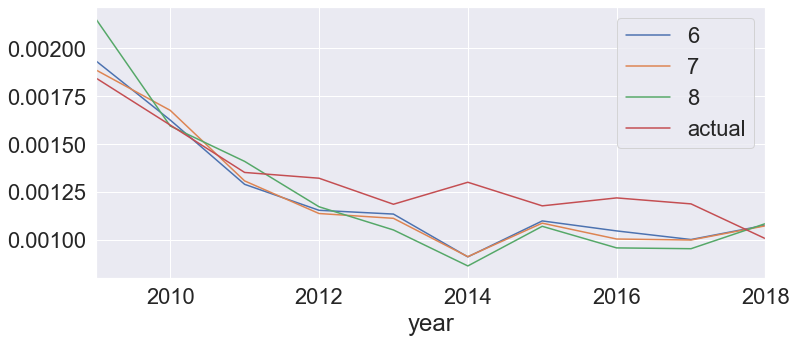

In [64]:
# plot the results
_ = pred_df.plot(figsize=(12, 5))
plt.show()

The predictions diverge to a greater extent from the actual proportions that were observed as the model gets further away from the observations in the training set. However, the smallest error comes from a lag order of 6. Therefore, this is the lag order that will be used to predict the proportion of baby's to be named Sarah in 2019.

In [65]:
LAG_ORDER = 6
model = ARIMA(X, order=(LAG_ORDER, DIFF, MOV_AVG))
fit_model = model.fit(disp=0)
forecast, stderr, conf_int = fit_model.forecast()

In [66]:
forecast

array([0.00070887])

This result indicates that about 0.07% of Social Security applications from California, Oregon, and Washington will have an applicant with the name Sarah.

### 5. State-specific Name Popularity

To finish this exploration of baby names based on Social Security applications, it would be interesting to understand how name popularity might have state-specific popularity trends. This exploration will be focused on male names in 2015. The goal is to find the male name in each state that is most "specific" to that state.

Term Frequency-Inverse Document Frequency (TF-IDF) is a frequency weighting technique from information retrieval which weights words that occur frequently in one or a few "documents" and decreases the weight of words that are common to a corpus of documents. In this analysis, states can be considered documents and the count of names will be transformed using this technique. The result will be scores that reflect the names most often associated to a particular state while keeping the weight of outliers low and, simultaneously, lowering the weights of names common to many of the states.

In [67]:
# get all male names by state in 2015 removing names provided as "Unknown" and "Male"
males_2015 = df[(df.sex=="M") & (df.year==2015) & (~df.name.isin(["Unknown", "Male"]))][["state", "name", "count"]]
males_2015.head()

,state,name,count
134451,IN,Liam,407
134452,IN,Noah,404
134453,IN,Oliver,384
134454,IN,Elijah,375
134455,IN,Mason,356


In [68]:
# create a matrix with states on rows and names on column to apply TF-IDF calculation
state_names = males_2015.pivot(index='state', columns='name', values='count').fillna(0)
state_names.head()

name,Aaden,Aadhav,Aadi,Aadit,Aaditya,Aadvik,Aahan,Aahil,Aaiden,Aamir,...,Zyan,Zyion,Zyir,Zylan,Zylen,Zyler,Zymere,Zymir,Zyon,Zyron
state,,,,,,,,,,,,,,,,,,,,,
AK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CA,34.0,8.0,6.0,6.0,0.0,7.0,7.0,11.0,13.0,9.0,...,8.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,7.0,0.0


In [69]:
tfidf = TfidfTransformer(sublinear_tf=True)
scores = tfidf.fit_transform(state_names)

In [70]:
scores_df = pd.DataFrame(scores.todense(), index=state_names.index.values, columns=state_names.columns.values)

The highest scoring male name for each state in 2015 can be found in the table below.

In [71]:
pd.DataFrame(scores_df.idxmax(axis=1), columns=["Name"])

,Name
AK,Paxson
AL,Crimson
AR,Rush
AZ,Iram
CA,Arley
CO,Aziah
CT,Remi
DC,Nahom
DE,Zyaire
FL,Demir


It's likely that many of the names have some underlying connection to the state to which they are associated. The one association that stands out the most to me is that Crimson is an Alabama specific name. This is a clear indication of the love that people from Alabama have for the University of Alabama team known as "The Crimson Tide".